In [29]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,  recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import dagshub
import pandas as pd
import os
import shutil
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import re

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/campusx-official/jupyter-masterclass/main/tweet_emotions.csv').drop(columns=['tweet_id'], axis=1)
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [23]:
df = df[df['sentiment'].isin(['happiness', 'sadness'])]
df.replace({'sentiment': {'happiness': 1, 'sadness': 0}}, inplace=True)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

C:\Users\use\AppData\Local\Temp\ipykernel_12336\1668646725.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'sentiment': {'happiness': 1, 'sadness': 0}}, inplace=True)


In [24]:
# Data Preprocessing
def lowercase_text(text: str) -> str:
    """
    Convert text to lowercase.
    """
    return str(text).lower()

def remove_urls(text: str) -> str:
    """
    Remove URLs from the text.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text: str) -> str:
    """
    Remove punctuation from the text.
    """
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_numbers(text: str) -> str:
    """
    Remove numbers from the text.
    """
    return re.sub(r'\d+', '', str(text))

def remove_stopwords(text: str) -> str:
    """
    Remove stopwords from the text.
    """
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text: str) -> str:
    """
    Lemmatize the text.
    """
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def fillna_with_empty(text: str) -> str:
    """
    Fill NaN values with empty strings.
    """
    if pd.isna(text):
        return ''
    return text

def preprocess_data(train_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocess the text data in the training and testing datasets.
    """
    for dataset in [train_data, test_data]:
        dataset['content'] = dataset['content'].apply(fillna_with_empty)
        dataset['content'] = dataset['content'].apply(lowercase_text)
        dataset['content'] = dataset['content'].apply(remove_urls)
        dataset['content'] = dataset['content'].apply(remove_punctuation)
        dataset['content'] = dataset['content'].apply(remove_numbers)
        dataset['content'] = dataset['content'].apply(remove_stopwords)
        dataset['content'] = dataset['content'].apply(lemmatize_text)

    return train_data, test_data

train_data, test_data = preprocess_data(train_data, test_data)

<>:19: SyntaxWarning: invalid escape sequence '\]'
<>:19: SyntaxWarning: invalid escape sequence '\]'
C:\Users\use\AppData\Local\Temp\ipykernel_12336\2839760033.py:19: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', str(text))


In [30]:

train_data['content'] = train_data['content'].fillna('').astype(str)
test_data['content'] = test_data['content'].fillna('').astype(str)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['content'])
y_train = train_data['sentiment']

X_test = vectorizer.transform(test_data['content'])
y_test = test_data['sentiment']

In [31]:
# Setup Dagshub and MLflow

mlflow.set_tracking_uri("https://dagshub.com/ChRaviTeja1901/mlops-mini-project.mlflow")
dagshub.init(repo_owner='ChRaviTeja1901', repo_name='mlops-mini-project', mlflow=True)

mlflow.set_experiment("Baseline Logistic Regression Text Classification")

Accessing as ChRaviTeja1901

Initialized MLflow to track repo "ChRaviTeja1901/mlops-mini-project"

Repository ChRaviTeja1901/mlops-mini-project initialized!

2025/12/25 21:15:37 INFO mlflow.tracking.fluent: Experiment with name 'Baseline Logistic Regression Text Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/55d2c6a640a44900bd1b8314e0a563bf', creation_time=1766677537361, experiment_id='1', last_update_time=1766677537361, lifecycle_stage='active', name='Baseline Logistic Regression Text Classification', tags={}>

2025/12/25 21:34:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run grandiose-midge-52 at: https://dagshub.com/ChRaviTeja1901/mlops-mini-project.mlflow/#/experiments/1/runs/c2ee86ad689f4ebb85c7703fc58aba36
🧪 View experiment at: https://dagshub.com/ChRaviTeja1901/mlops-mini-project.mlflow/#/experiments/1


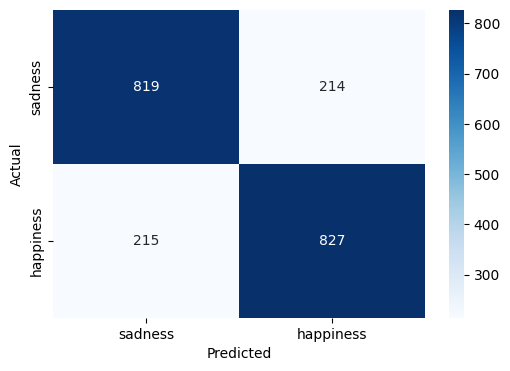

In [35]:
with mlflow.start_run():
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("vectorizer", "CountVectorizer")
    mlflow.log_param("preprocessing_steps", ["lowercase", "remove_urls", "remove_punctuation", "remove_numbers", "remove_stopwords", "lemmatization"])
    mlflow.log_param("test size", 0.2)

    # Train the Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #check scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sadness', 'happiness'], yticklabels=['sadness', 'happiness'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.sklearn.log_model(model, "logistic_regression_model")

    notebook_path = os.path.abspath("exp1_baseline_model.ipynb")
    os.system(f"jupyter nbconvert --to script --execute --inplace {notebook_path}")
    mlflow.log_artifact(notebook_path)
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)